In [1]:
from __future__ import print_function

import logging
import pandas as pd
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

In [132]:
# Define default labels
labels = ['Fatos', 'Normas', 'Argumentos', 'Pedidos', 'Irrelevante']

# Define stopwords list
stopwords = []

raw_data = pd.read_csv('C:\Users\pedro.castanha\Downloads\ML_Gabinete_Digital.csv', error_bad_lines=False, sep='\t', encoding='utf_8')
words = pd.read_table('C:\Users\pedro.castanha\Downloads\stoplists\stopwords_pt_br.txt', encoding='mbcs')

stopwords = words.values.T.tolist()[0]

x_vectorized = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df=0.5, stop_words=stopwords)
x_vectorized.fit(raw_data.Text)
x_train = x_vectorized.transform(raw_data.Text)
y_train = raw_data.Class

names = np.asarray(x_vectorized.get_feature_names())

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

Load some categories from the training set


In [2]:
#if opts.all_categories:
#    categories = None

categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
]

#if opts.filtered:
#    remove = ('headers', 'footers', 'quotes')
#else:
remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(categories))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
#if opts.use_hashing:
#    vectorizer = HashingVectorizer(stop_words='english', non_negative=True,
#                                   n_features=opts.n_features)
#    X_train = vectorizer.transform(data_train.data)
#else:
vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
#if opts.use_hashing:
#    feature_names = None
#else:
feature_names = vectorizer.get_feature_names()

#if opts.select_chi2:
#    print("Extracting %d best features by a chi-squared test" %
#          opts.select_chi2)
#    t0 = time()
#    ch2 = SelectKBest(chi2, k=opts.select_chi2)
#    X_train = ch2.fit_transform(X_train, y_train)
#    X_test = ch2.transform(X_test)
#    if feature_names:
        # keep selected feature names
#        feature_names = [feature_names[i] for i
#                         in ch2.get_support(indices=True)]
#    print("done in %fs" % (time() - t0))
#    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

Extracting features from the training data using a sparse vectorizer
done in 0.592000s at 6.722MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.381000s at 7.526MB/s
n_samples: 1353, n_features: 33809



In [15]:
cl = SGDClassifier(alpha=0.000868511373751352, n_iter=50, l1_ratio=0.0035564803062231283, penalty="elasticnet")


In [32]:
# Init - PCA Dim. reduction
print("Projecting the input data...")
t0 = time()

svd = TruncatedSVD(n_components=2000, algorithm='randomized',).fit(X_train.toarray())
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)

X_train = normalize(X_train)
X_test = normalize(X_test)

print("Done in: %0.3fs" % (time() - t0))
# End - PCA Dim. reduction

Projecting the input data...
Done in: 54.041s


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.120s
test time:  0.006s
accuracy:   0.902
dimensionality: 2000
density: 1.000000
top 10 keywords per class:
alt.atheism: 00041032 0029 01a 001555 000usd 000005102000 0001 000100255pixel...
comp.graphics: 0039 011634edt 013034 0901 02115 000062david42 0000vec 0049 00...
sci.space: 012536 083731 0033 034 000406 000005102000 00196 0004136 01854 00000
talk.religion.misc: 003719 001757 0511 013034 0010580b 00090711 0100 000 0000...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.84      0.87      0.85       319
     comp.graphics       0.94      0.97      0.95       389
         sci.space       0.95      0.95      0.95       394
talk.relig

C:\Users\pedro.castanha\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 1.563s
test time:  0.005s
accuracy:   0.903
dimensionality: 2000
density: 1.000000
top 10 keywords per class:
alt.atheism: 000062david42 0029 001555 01a 000usd 0001 00 000005102000 000100...
comp.graphics: 0184 013034 02115 011634edt 0049 0901 0000vec 000062david42 00...
sci.space: 083731 012536 000005102000 034 0033 000406 00196 0004136 01854 00000
talk.religion.misc: 003719 013034 001757 0010580b 0511 00090711 0100 000 0000...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.85      0.86      0.85       319
     comp.graphics       0.94      0.96      0.95       389
         sci.space       0.94      0.95      0.95       394
talk.religion.misc       0.84      0.78      0.81       251

       avg / total       0.90      0.90      0.90      1353

confusion matrix:
[[275   2   9  33]
 [  3 375   7   4]
 [  3  15 376   0]
 [ 44   5   6 196]]

________________________________________________________________________

C:\Users\pedro.castanha\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\svm\classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 1.983s
test time:  0.000s
accuracy:   0.901
dimensionality: 2000
density: 0.082125
top 10 keywords per class:
alt.atheism: 01a 0029 001555 0001 095220 000062david42 000usd 000100255pixel ...
comp.graphics: 013034 0018 02115 011634edt 0901 0000vec 0049 0184 0004847546 ...
sci.space: 012536 141137 041929 01821 000406 00196 0004136 0033 01854 00000
talk.religion.misc: 003719 02138 013034 071814 0511 001757 0100 000 0004246 0000

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.84      0.87      0.86       319
     comp.graphics       0.95      0.95      0.95       389
         sci.space       0.91      0.98      0.94       394
talk.religion.misc       0.87      0.75      0.80       251

       avg / total       0.90      0.90      0.90      1353

confusion matrix:
[[277   4  13  25]
 [  4 370  13   2]
 [  0   9 385   0]
 [ 47   5  12 187]]

____________________________________________________________________________

C:\Users\pedro.castanha\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\pedro.castanha\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


train time: 1.772s
test time:  0.000s
accuracy:   0.908
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.84      0.87      0.85       319
     comp.graphics       0.95      0.97      0.96       389
         sci.space       0.95      0.97      0.96       394
talk.religion.misc       0.85      0.78      0.81       251

       avg / total       0.91      0.91      0.91      1353

confusion matrix:
[[276   4   8  31]
 [  4 376   5   4]
 [  1  12 381   0]
 [ 46   4   6 195]]



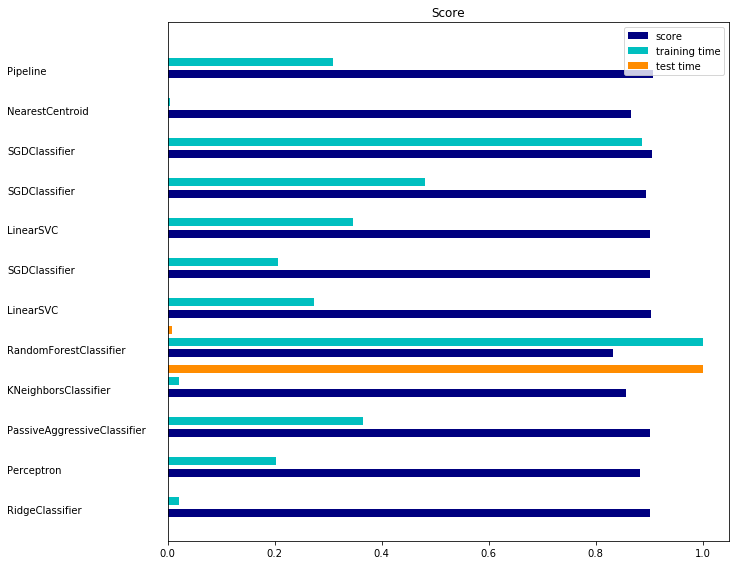

In [33]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    #clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    #pred = clf.predict(x_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if True and feature_names is not None:
        #if True and names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
            #for i, label in enumerate(labels):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
                #print(trim("%s: %s" % (label, " ".join(names[top10]))))
        print()

    if True:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if True:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
#results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
#                                       penalty="elasticnet")))

# 'alpha': 0.000868511373751352, 'l1_ratio': 0.0035564803062231283
results.append(benchmark(SGDClassifier(alpha=0.000868511373751352, n_iter=50,
                                       l1_ratio=0.0035564803062231283, penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
#results.append(benchmark(MultinomialNB(alpha=.01)))
#results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [130]:
raw_data = pd.read_csv('C:\Users\pedro.castanha\Downloads\ML_Gabinete_Digital.csv', error_bad_lines=False, sep='\t', encoding='utf_8')
words = pd.read_table('C:\Users\pedro.castanha\Downloads\stoplists\stopwords_pt_br.txt', encoding='mbcs')

stopwords = words.values.T.tolist()[0]

x_vectorized = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stopwords)
x_vectorized.fit(raw_data.Text)
x_train = x_vectorized.transform(raw_data.Text)
y_train = raw_data.Class

names = np.asarray(x_vectorized.get_feature_names())

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

clf = MultinomialNB(alpha=.01)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(metrics.classification_report(y_test, y_pred, target_names=labels))

for i, label in enumerate(labels):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print(trim("%s: %s" % (label, " ".join(names[top10]))))

             precision    recall  f1-score   support

      Fatos       0.73      0.68      0.70        47
     Normas       0.70      0.72      0.71        43
 Argumentos       0.43      0.52      0.47        44
    Pedidos       0.55      0.71      0.62        34
Irrelevante       0.76      0.60      0.67        85

avg / total       0.66      0.64      0.64       253

Fatos: nº réu reclamante anexo qualquer 00 data imóvel conforme requerente
Normas: ser qualquer atos ato processual processo iii lei ii art
Argumentos: protesto réu ré razão requerente requerida imóvel assim autor ser
Pedidos: advocatícios custas bem 20 honorários juros processuais pagamento co...
Irrelevante: tutela direito contrato moral mais posse exposto dano ação pedido
